#### YOLOv5 (04월 28일)

- 탄저병 제외하고, 흰가루병, 정상 데이터의 이미지 전처리 전반적인 코드 작성
- 이미지 전처리 과정에서 시간이 오래 걸려서 ver2에서 train_test_split 하지 않고, 이미 분리된 파일을 바탕으로 라벨 조합하여 사용
- 이미 분리된 파일을 전달받아 라벨 데이터도 그에 맞게 분류해서 저장 (json 형태로)
- runs/yolov5_results_ver

#### YOLOv5 (05월 05일)

- 노균병 이미지, 라벨 데이터 추가
- 모델링 추가로 진행
- runs/yolov5_results_ver2

#### 데이터 로드 후 확장자 변경 (.jpg)

In [2]:
import os, shutil
from glob import glob

In [3]:
os.getcwd()  # 현재 경로 확인

'/home/jngmk/Downloads'

In [4]:
original_dataset_dir = '/home/jngmk/Downloads/datasets/dataset/'  # 원본 데이터셋 디렉터리

In [7]:
# 식물병 리스트
disease_list = os.listdir(original_dataset_dir)
print(disease_list)

# 식물병 이미지 데이터 확장자명 .jpg로 맞추기
# for i in disease_list:
#     img_files = glob('/home/jngmk/Downloads/datasets/Disease/'+i+'/images/*')

#     for name in img_files:
#         if not os.path.isdir(name):         # 디렉토리는 포함안함
#             src = os.path.splitext(name)    # 확장자와 파일명 구분
#             os.rename(name, src[0] + '.jpg')

#     print(f'{i} 이미지 수 : {len(img_files)}')

# 정상 이미지 데이터 확장자명 .jpg로 맞추기 (고추 뺴고)
img_files_2 = glob('/home/jngmk/Downloads/datasets/dataset/normal_addition/*')

for name in img_files_2:
    if not os.path.isdir(name):
        src = os.path.splitext(name)
        os.rename(name, src[0] + '.jpg')

print(f'정상 이미지 수 (고추 제외) : {len(img_files_2)}')

# 노균병 이미지 데이터 확장자명 .jpg로 맞추기
img_files = glob('/home/jngmk/Downloads/datasets/dataset/downy_mildew/*')

for name in img_files:
    if not os.path.isdir(name):
        src = os.path.splitext(name)
        os.rename(name, src[0] + '.jpg')

print(f'노균병 이미지 수 : {len(img_files)}')

['normal_addition', 'labels_all', 'downy_mildew']
정상 이미지 수 (고추 제외) : 50555
노균병 이미지 수 : 3333


#### 데이터셋 저장할 디렉터리 생성 (copy)
- 0505 : 용량이 부족해서 move로 이동

In [47]:
# 데이터셋을 저장할 디렉터리 (copy)
# base_dir = '/home/jngmk/Downloads/datasets/Disease_copy'
# os.mkdir(base_dir)

In [5]:
# 이미지 데이터셋 저장할 디렉터리 (copy)
# base_images_dir = os.path.join(base_dir, 'images')
# os.mkdir(base_images_dir)

# 라벨 데이터셋(txt) 저장할 디렉터리 (copy)
# base_labels_dir = os.path.join(base_dir, 'labels')
# os.mkdir(base_labels_dir)

In [5]:
# 훈련, 검증, 테스트 분할을 위한 디렉터리
# 이 안에 식물병 종류별로 폴더를 생성해서 데이터를 나눠서 복사할 것

# 이미지
train_images_dir = "/home/jngmk/Downloads/datasets/yolov5/dataset/images/train"
validation_images_dir = "/home/jngmk/Downloads/datasets/yolov5/dataset/images/validation"
test_images_dir = "/home/jngmk/Downloads/datasets/yolov5/dataset/images/test"

# os.mkdir(train_images_dir)
# os.mkdir(validation_images_dir)
# os.mkdir(test_images_dir)

labels_dir은 yolov5에서 사용하는 txt 파일을 저장할 폴더

In [6]:
# 라벨 (txt 파일)
train_labels_dir = "/home/jngmk/Downloads/datasets/yolov5/dataset/labels/train"
validation_labels_dir = "/home/jngmk/Downloads/datasets/yolov5/dataset/labels/validation"
test_labels_dir = "/home/jngmk/Downloads/datasets/yolov5/dataset/labels/test"

# os.mkdir(train_labels_dir)
# os.mkdir(validation_labels_dir)
# os.mkdir(test_labels_dir)

labels_json_dir은 이미지 파일에 맞는 json 파일을 임시로 저장할 폴더

In [7]:
# 라벨 데이터셋(임시 json) 저장할 디렉터리 (copy)
base_labels_json_dir = '/home/jngmk/Downloads/datasets/dataset/labels_tmp'
# os.mkdir(base_labels_json_dir)

# 라벨 (json 변환 전)
train_labels_json_dir = os.path.join(base_labels_json_dir, 'train')
validation_labels_json_dir = os.path.join(base_labels_json_dir, 'validation')
test_labels_json_dir = os.path.join(base_labels_json_dir, 'test')

# os.mkdir(train_labels_json_dir)
# os.mkdir(validation_labels_json_dir)
# os.mkdir(test_labels_json_dir)

#### 이미지, 라벨 파일 전처리 (흰가루병, 정상, 노균병)

- 잎 부위 촬영이 아닌 사진은 리스트에서 제외 (잎 03)
- 흰가루병에 해당하는 사진만 가져오기 (고추 02, 애호박 08, 오이 12, 호박 20)
- 노균병에 해당하는 사진만 가져오기 (오이 04, 배추 09, 애호박 11, 무 14, 파 16, 호박 20)


- 파일이름: V006_과제번호(79)_질병(0/1)_질병코드(흰가루병20)_작물코드(호박10)_촬영부위코드(잎 03)_작물생육코드(생장기 12)_해충피해코드(정상0 초기1 중기2 말기3)
- 질병코드 idx 3 / 작물코드 idx 4 / 촬영부위코드 idx 5

In [8]:
# 숨김파일 제외: os.listdir('파일경로')를 하면 숨겨진 파일도 함께 불러내므로 제외해야 함
def hidden_file(path):
    filenames = [f for f in os.listdir(path) if not f.startswith('.')]
    return filenames

In [9]:
## 잎 부위 촬영이 아니면 제외하는 함수 (잎 코드는 03)
def leaf_files(files):
    remove_list = []
    for file in files:

        # 잎이 아닌 데이터면 remove_list에 추가
        if file.split('_')[5] != '03':
            remove_list.append(file)

    # 잎 데이터만 new_datas에 추가
    new_datas = [x for x in files if x not in remove_list]
    
    return new_datas

In [10]:
## 흰가루병에 해당하는 사진이 아니면 제외
# 질병코드(index 3): 고추 02, 애호박 08, 오이 12, 호박 20
# 작물코드(index 4): 고추 01, 애호박 04, 오이 06, 호박 10

def powdery_files(files):

    # 해당 작물 + 흰가루병인 경우만 리스트에 추가
    powdery_disease = []
    
    # 모든 이미지 불러오기
    for file in files:
        disease = file.split('_')[3]
        crops = file.split('_')[4]

        if disease == '02' and crops == '01': powdery_disease.append(file)     # 고추
        elif disease == '08' and crops == '04' : powdery_disease.append(file)  # 애호박
        elif disease == '12' and crops == '06' : powdery_disease.append(file)  # 오이
        elif disease == '20' and crops == '10' : powdery_disease.append(file)  # 호박

    return powdery_disease

In [11]:
## 노균병에 해당하는 사진이 아니면 제외
# 질병코드(index 3): 오이 11, 애호박 07, 무 04, 호박 19
# 작물코드(index 4): 오이 06, 애호박 04, 무 02, 호박 10

def downy_files(files):

    # 해당 작물 + 노균병인 경우만 리스트에 추가
    downy_disease = []
    
    # 모든 이미지 불러오기
    for file in files:
        disease = file.split('_')[3]
        crops = file.split('_')[4]

        if disease == '11' and crops == '06': downy_disease.append(file)     # 오이
        elif disease == '07' and crops == '04' : downy_disease.append(file)  # 애호박
        elif disease == '04' and crops == '02' : downy_disease.append(file)  # 무
        elif disease == '19' and crops == '10' : downy_disease.append(file)  # 호박

    return downy_disease

(1) 흰가루병 이미지 전처리

In [17]:
# 정제되지 않은 이미지 전체 불러오기
# img_files은 리스트 형태
img_files = glob('/home/jngmk/data/Disease/powdery_mildew/images/*')
print(len(img_files))

4653


In [18]:
img_files_new = []

for i in range(len(img_files)):
    img_files_new.append(os.path.basename(img_files[i]))

In [19]:
# 잎 데이터만 추출
leaf_img = leaf_files(img_files_new)
print(len(leaf_img))

3561


In [20]:
# 흰가루병 데이터만 추출 (잎으로 한번 정제된 데이터 사용)
powdery_img = powdery_files(leaf_img)
print(len(powdery_img))

2265


(2) 정상 이미지 이미지 전처리

고추 이미지

In [84]:
img_tmp = glob('/home/jngmk/data/Disease/normal_data/images/*')
print(len(img_tmp))

47936


In [85]:
### 고추 이미지

# 경로에서 파일 제목만 불러오기
img_name = []

for i in range(len(img_tmp)):
    img_name.append(os.path.basename(img_tmp[i]))

print(len(img_name))

# 고추 이미지만 리스트에 저장
image = []

for img in img_name:
    crops = img.split('_')[4]

    # 고추인 경우
    if crops == '01':
        image.append(img)

print(len(image))

# 잎 데이터만 추출
pepper_img = leaf_files(image)
print(len(pepper_img))

47936
9685
2307


오이, 애호박, 무, 호박 이미지

In [86]:
# 정제되지 않은 이미지 전체 불러오기
# img_tmp2는 리스트 형태
img_tmp2 = glob('/home/jngmk/Downloads/datasets/dataset/normal_addition/*')
print(len(img_tmp2))

50555


In [87]:
# 경로에서 파일 제목만 불러오기
img_name2 = []

for i in range(len(img_tmp2)):
    img_name2.append(os.path.basename(img_tmp2[i]))

print(len(img_name2))

50555


In [88]:
### 오이 이미지

# 오이 이미지만 리스트에 저장
image2 = []

for img in img_name2:
    crops = img.split('_')[4]

    # 오이인 경우
    if crops == '06':
        image2.append(img)

print(len(image2))

# 잎 데이터만 추출
cucumber_img = leaf_files(image2)
print(len(cucumber_img))

14477
6345


In [89]:
### 애호박 이미지

# 애호박 이미지만 리스트에 저장
image3 = []

for img in img_name2:
    crops = img.split('_')[4]

    # 애호박인 경우
    if crops == '04':
        image3.append(img)

print(len(image3))

# 잎 데이터만 추출
squash_img = leaf_files(image3)
print(len(squash_img))

11911
5358


In [90]:
### 무 이미지

# 무 이미지만 리스트에 저장
image4 = []

for img in img_name2:
    crops = img.split('_')[4]

    # 무인 경우
    if crops == '02':
        image4.append(img)

print(len(image4))

# 잎 데이터만 추출
radish_img = leaf_files(image4)
print(len(radish_img))

12304
12304


In [91]:
### 호박 이미지

# 호박 이미지만 리스트에 저장
image5 = []

for img in img_name2:
    crops = img.split('_')[4]

    # 무인 경우
    if crops == '10':
        image5.append(img)

print(len(image5))

# 잎 데이터만 추출
pumpkin_img = leaf_files(image5)
print(len(pumpkin_img))

11863
7266


In [100]:
# 고추
len(pepper_img[0:600])

600

In [98]:
# 오이 + 애호박 + 무 + 호박
normal_img = cucumber_img[0:600] + squash_img[0:600] + radish_img[0:600] + pumpkin_img[0:600]
len(normal_img)

2400

(3) 노균병 이미지 전처리

In [93]:
# 정제되지 않은 이미지 전체 불러오기
# img_tmp3는 리스트 형태
img_tmp3 = glob('/home/jngmk/Downloads/datasets/dataset/downy_mildew/*')
print(len(img_tmp3))

3333


In [94]:
# 경로에서 파일 제목만 불러오기
img_name3 = []

for i in range(len(img_tmp3)):
    img_name3.append(os.path.basename(img_tmp3[i]))

print(len(img_name3))

# 잎 데이터만 추출 (최종 정상 데이터)
leaf_img_2 = leaf_files(img_name3)
print(len(leaf_img_2))

# 노균병 데이터만 추출 (잎으로 한번 정제된 데이터 사용)
downy_img = downy_files(leaf_img_2)
print(len(downy_img))

3333
3331
1546


#### 이미지 데이터 train_test_split

In [12]:
from sklearn.model_selection import train_test_split

In [95]:
### 흰가루병 데이터

# 학습 데이터와 테스트 데이터 분리 (train:test = 8:2)
train_img_powdery, test_img_powdery = train_test_split(powdery_img, test_size=0.2, random_state=44)

# 학습 데이터와 검증 데이터 분리 (train:validation = 8:2)
train_img_powdery, val_img_powdery = train_test_split(train_img_powdery, test_size=0.2, random_state=44)

print('train 데이터: ', len(train_img_powdery))
print('valid 데이터: ', len(val_img_powdery))
print('test 데이터: ', len(test_img_powdery))

train 데이터:  1449
valid 데이터:  363
test 데이터:  453


In [114]:
### 정상 데이터 (고추만)

# 학습 데이터와 테스트 데이터 분리 (train:test = 8:2)
train_img_pepper, test_img_pepper = train_test_split(pepper_img[0:600], test_size=0.2, random_state=44)

# 학습 데이터와 검증 데이터 분리 (train:validation = 8:2)
train_img_pepper, val_img_pepper = train_test_split(train_img_pepper, test_size=0.2, random_state=44)

print('train 데이터: ', len(train_img_pepper))
print('valid 데이터: ', len(val_img_pepper))
print('test 데이터: ', len(test_img_pepper))

train 데이터:  384
valid 데이터:  96
test 데이터:  120


In [102]:
### 정상 데이터 (고추 제외)

# 학습 데이터와 테스트 데이터 분리 (train:test = 8:2)
train_img_normal, test_img_normal = train_test_split(normal_img, test_size=0.2, random_state=44)

# 학습 데이터와 검증 데이터 분리 (train:validation = 8:2)
train_img_normal, val_img_normal = train_test_split(train_img_normal, test_size=0.2, random_state=44)

print('train 데이터: ', len(train_img_normal))
print('valid 데이터: ', len(val_img_normal))
print('test 데이터: ', len(test_img_normal))

train 데이터:  1536
valid 데이터:  384
test 데이터:  480


In [97]:
### 노균병 데이터

# 학습 데이터와 테스트 데이터 분리 (train:test = 8:2)
train_img_downy, test_img_downy = train_test_split(downy_img, test_size=0.2, random_state=44)

# 학습 데이터와 검증 데이터 분리 (train:validation = 8:2)
train_img_downy, val_img_downy = train_test_split(train_img_downy, test_size=0.2, random_state=44)

print('train 데이터: ', len(train_img_downy))
print('valid 데이터: ', len(val_img_downy))
print('test 데이터: ', len(test_img_downy))

train 데이터:  988
valid 데이터:  248
test 데이터:  310


#### 이미지 데이터 yolov5/dataset 폴더로 이동

- yolov5/dataset

    - images

        - train (train_images_dir)
        - validation (validation_images_dir)
        - test (test_images_dir)

    -------------------------------------------------------'

    - labels

        - train (train_labels_dir)
        - validation (validation_labels_dir)
        - test (test_labels_dir)
    
    -------------------------------------------------------'

    - labels_tmp

        - train (train_labels_json_dir)
        - validation (validation_labels_json_dir)
        - test (test_labels_json_dir)

- YOLOv5는 라벨이 있으므로 따로 종류를 구분하지 않고 train, val, test에 한번에 저장

In [106]:
### 흰가루병 데이터

# train
for train_img in train_img_powdery:
    
    # src라는 파일을 dst에 복사함
    # src와 dst는 문자열 string으로 주어지는 경로명이고, dst가 이미 존재하면 대체됨
    src = os.path.join('/home/jngmk/data/Disease/powdery_mildew/images/', train_img)
    dst = os.path.join(train_images_dir, train_img)
    shutil.move(src, dst)
    
# validation
for valid_img in val_img_powdery:
    src = os.path.join('/home/jngmk/data/Disease/powdery_mildew/images/', valid_img)
    dst = os.path.join(validation_images_dir, valid_img)
    shutil.move(src, dst)
    
# test
for test_img in test_img_powdery:
    src = os.path.join('/home/jngmk/data/Disease/powdery_mildew/images/', test_img)
    dst = os.path.join(test_images_dir, test_img)
    shutil.move(src, dst)

In [113]:
### 정상 데이터 (고추만)

# train
for train_img in train_img_pepper:
    src = os.path.join('/home/jngmk/data/Disease/normal_data/images/', train_img)
    dst = os.path.join(train_images_dir, train_img)
    shutil.move(src, dst)

# validation
for valid_img in val_img_pepper:
    src = os.path.join('/home/jngmk/data/Disease/normal_data/images/', valid_img)
    dst = os.path.join(validation_images_dir, valid_img)
    shutil.move(src, dst)

# test
for test_img in test_img_pepper:
    src = os.path.join('/home/jngmk/data/Disease/normal_data/images/', test_img)
    dst = os.path.join(test_images_dir, test_img)
    shutil.move(src, dst)

In [115]:
### 정상 데이터 (고추 제외)

# train
for train_img in train_img_normal:
    src = os.path.join('/home/jngmk/Downloads/datasets/dataset/normal_addition/', train_img)
    dst = os.path.join(train_images_dir, train_img)
    shutil.move(src, dst)

# validation
for valid_img in val_img_normal:
    src = os.path.join('/home/jngmk/Downloads/datasets/dataset/normal_addition/', valid_img)
    dst = os.path.join(validation_images_dir, valid_img)
    shutil.move(src, dst)

# test
for test_img in test_img_normal:
    src = os.path.join('/home/jngmk/Downloads/datasets/dataset/normal_addition/', test_img)
    dst = os.path.join(test_images_dir, test_img)
    shutil.move(src, dst)

In [116]:
### 노균병 데이터 복사

# train
for train_img in train_img_downy:
    src = os.path.join('/home/jngmk/Downloads/datasets/dataset/downy_mildew/', train_img)
    dst = os.path.join(train_images_dir, train_img)
    shutil.move(src, dst)

# validation
for valid_img in val_img_downy:
    src = os.path.join('/home/jngmk/Downloads/datasets/dataset/downy_mildew/', valid_img)
    dst = os.path.join(validation_images_dir, valid_img)
    shutil.move(src, dst)

# test
for test_img in test_img_downy:
    src = os.path.join('/home/jngmk/Downloads/datasets/dataset/downy_mildew/', test_img)
    dst = os.path.join(test_images_dir, test_img)
    shutil.move(src, dst)

In [13]:
train_images = os.listdir(train_images_dir)
valid_images = os.listdir(validation_images_dir)
test_images = os.listdir(test_images_dir)

print(len(train_images), len(valid_images), len(test_images))

4357 1091 1363


#### 라벨 데이터 labels_tmp으로 복사

In [14]:
# 라벨 경로 (흰가루병, 정상 고추)
label_route = ('/home/jngmk/Downloads/datasets/dataset/labels_all')
print(label_route)  # raw 데이터의 라벨이 있는 경로

# 라벨 리스트
label_list = os.listdir(label_route)
print(len(label_list))

/home/jngmk/Downloads/datasets/dataset/labels_all
58879


In [125]:
# 테스트
cnt = 0

for label in label_list:
    # print(label)
    # print(train_images[8].split('.')[0])
    # print(label_all[label].split('.')[0])
    if test_images[900].split('.')[0] == label.split('.')[0]:
        print('True!')
    else:
        cnt += 1

print(cnt)

True!
65689


In [126]:
# 이미지 데이터와 맞는 label 파일 -> label_tmp 파일에 복사

data_list = [train_images, valid_images, test_images]

for data in data_list:

    # train 데이터
    if data == train_images:
        for label in label_list:
            for image in train_images:

                # 뒤에 확장자명 뺀 이름이 같을 경우
                if image.split('.')[0] == label.split('.')[0]:

                    # 라벨 데이터 labels_tmp/train으로 파일 복사
                    src = os.path.join(label_route, label)
                    dst = os.path.join(train_labels_json_dir, label)

                    # copyfile: 복사하고 싶은 파일 (경로 포함), 복사할 대상 파일명 (경로 포함)
                    shutil.move(src, dst) 

    # validation 데이터
    elif data == valid_images:
        for label in label_list:
            for image in valid_images:
                
                # 뒤에 확장자명 뺀 이름이 같을 경우
                if image.split('.')[0] == label.split('.')[0]:

                    # 라벨 데이터 labels_tmp/validation으로 파일 복사
                    src = os.path.join(label_route, label)
                    dst = os.path.join(validation_labels_json_dir, label)

                    # copyfile: 복사하고 싶은 파일 (경로 포함), 복사할 대상 파일명 (경로 포함)
                    shutil.move(src, dst) 

    # test 데이터
    elif data == test_images:
        for label in label_list:
            for image in test_images:

                # 뒤에 확장자명 뺀 이름이 같을 경우
                if image.split('.')[0] == label.split('.')[0]:

                    # 라벨 데이터 labels_tmp/test으로 파일 복사
                    src = os.path.join(label_route, label)
                    dst = os.path.join(test_labels_json_dir, label)

                    # copyfile: 복사하고 싶은 파일 (경로 포함), 복사할 대상 파일명 (경로 포함)
                    shutil.move(src, dst)

In [15]:
# 복사된 데이터 수 확인 (라벨)
print('훈련용 라벨 개수 :', len(os.listdir(train_labels_json_dir)))
print('valid 라벨 개수 :', len(os.listdir(validation_labels_json_dir)))
print('test 라벨 개수 :', len(os.listdir(test_labels_json_dir)))

훈련용 라벨 개수 : 4357
valid 라벨 개수 : 1091
test 라벨 개수 : 1363


#### 라벨 데이터 json -> txt 파일로 변환 후 새로운 파일로 저장

In [ ]:
'''
{
    "description": {
        "image": "V006_79_1_07_04_03_12_1_5950b_20201024_2.jpeg",  # 파일 이름
        "date": "2020/10/24",   # 취득 일자
        "worker": "",           # 촬영 지역
        "height": 2268,         # 이미지 높이
        "width": 4032,          # 이미지 너비
        "task": 79,             # 과제 번호
        "type": 1,              # 촬영 유형
        "region": 3
    },
    "annotations": {
        "disease": 7,           # 질병/해충 코드
        "crop": 4,              # 작물 코드
        "area": 3,              # 촬영 부위
        "grow": 12,             # 작물 생육단계
        "risk": 1,              # 질병 피해 정도 (숫자가 커질수록 피해가 큼)
        "points": [             # 주목 객체의 bbox 좌표
            {
                "xtl": 263,
                "ytl": 0,
                "xbr": 3513,
                "ybr": 2250
            }
        ]
    }
}
'''

In [16]:
# 바운딩박스 포맷 YOLO 형태로 바꿔주기
# YOLO bounding box 형태 : [x_center, y_center, width, height]

def convert_bbox_yolov5(img_width, img_height, bbox):
    
    x_tl, y_tl, w, h = bbox

    dw = 1.0 / img_width
    dh = 1.0 / img_height

    x_center = x_tl + w / 2.0
    y_center = y_tl + h / 2.0

    x = x_center * dw
    y = y_center * dh
    w = w * dw
    h = h * dh

    return [x, y, w, h]

In [17]:
# json => txt 파일로 변환
# lables_tmp에서 json 파일 꺼내와서 새로 생성된 txt 파일은 lables에 저장

import json
from tqdm import tqdm

def convert_json_to_txt(output_path, json_file): # txt 파일 저장될 경로, 불러올 json 파일
    
    # json 파일 불러오기
    with open(json_file) as f:
        json_data = json.load(f)

    # json 파일에 있는 정보 가져오기
    img_name = json_data['description']['image']
    img_width = json_data['description']['width']
    img_height = json_data['description']['height']

    disease = json_data['annotations']['disease']
    # 정상은 0
    
    # 흰가루병인 경우 클래스명 1로 통일
    # 순서대로 고추흰가루병, 애호박흰가루병, 오이흰가루병, 호박흰가루병
    if disease == 2 or disease == 8 or disease == 12 or disease == 20: disease = 1

    # 노균병인 경우 클래스명 2로 통일
    # 순서대로 오이노균병, 애호박노균병, 무노균병, 호박노균병
    elif disease == 11 or disease == 7 or disease == 4 or disease == 19: disease = 2

    # txt 파일 작성
    label_txt = os.path.join(output_path, img_name.split('.')[0] + '.txt')

    # points가 리스트에 한 번 더 감싸져 여러 개가 있을 수 있으므로 for문 사용
    points = json_data['annotations']['points']

    for point in points:
        # points 형태: {'xtl': 1829, 'ytl': 398, 'xbr': 2338, 'ybr': 1067}
        # point 형태: {'xtl': 1829, 'ytl': 398, 'xbr': 2338, 'ybr': 1067}
        xtl = point['xtl']
        ytl = point['ytl']
        xbr = point['xbr']
        ybr = point['ybr']

        with open(label_txt, 'w') as f:
            bbox = [xtl, ytl, xbr, ybr]
            x, y, w, h = convert_bbox_yolov5(img_width, img_height, bbox)
            f.write(f"{disease} {x:.6f} {y:.6f} {w:.6f} {h:.6f}\n")

In [134]:
# 함수 사용해서 json => txt로 변환

# train 데이터
train_labels = os.listdir(train_labels_json_dir)

for label_json in train_labels:
    json_file = os.path.join(train_labels_json_dir, label_json)
    convert_json_to_txt(train_labels_dir, json_file)

# validation 데이터
valid_labels = os.listdir(validation_labels_json_dir)

for label_json in valid_labels:
    json_file = os.path.join(validation_labels_json_dir, label_json)
    convert_json_to_txt(validation_labels_dir, json_file)

# test 데이터
test_labels = os.listdir(test_labels_json_dir)

for label_json in test_labels:
    json_file = os.path.join(test_labels_json_dir, label_json)
    convert_json_to_txt(test_labels_dir, json_file)

In [18]:
# 만들어진 라벨 데이터 수 확인
print('훈련용 라벨 개수 :', len(os.listdir(train_labels_dir)))
print('valid 라벨 개수 :', len(os.listdir(validation_labels_dir)))
print('test 라벨 개수 :', len(os.listdir(test_labels_dir)))

훈련용 라벨 개수 : 4357
valid 라벨 개수 : 1091
test 라벨 개수 : 1363


#### YOLOv5 Model 불러오기

Yolov5 모델구조 => 이미지, 라벨 파일 bash 창에서 이동

- dataset
    -  images
        - test
        - train
        - validation
    - labels
        - test
        - train
        - validation
    
- data
    - data.yaml\
        [path: root 디렉토리,\
        train: images/train 학습 데이터 경로\
        val: images/validation 검증 데이터 경로\
        test: images/test 테스트 데이터 경로\
        nc: 2 클래스 수\
        name: ['...', '...'] 클래스 이름]

In [19]:
# 이미지 경로 변경 (yolov5/dataset으로 변경)
# base_dir_new = '/home/jngmk/Downloads/datasets/yolov5/dataset'

# 복사된 이미지 개수 확인
train_images = os.listdir(train_images_dir)
validation_images = os.listdir(validation_images_dir)
test_images = os.listdir(test_images_dir)

print(len(train_images), len(validation_images), len(test_images))

4357 1091 1363


In [20]:
cd '/home/jngmk/Downloads/datasets/yolov5/'

/home/jngmk/Downloads/datasets/yolov5


In [21]:
os.getcwd()

'/home/jngmk/Downloads/datasets/yolov5'

In [141]:
# 아래에서 이미지를 못 읽어옴

# opencv로 파일 열어서 다시 저장하기 
# 오류 해결 가능 => UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7f9e185347d0> 

import PIL, glob
import cv2
from tqdm import tqdm

imgs_ = glob.glob(f"./dataset/images/*/*")

def imageRefine(image):
    for img in tqdm(image):
        try:
            src = cv2.imread(img, cv2.IMREAD_UNCHANGED)
            cv2.imwrite(img, src)

        except PIL.UnidentifiedImageError:
            print(img)
            cv2.imwrite(img, src)

imageRefine(imgs_)

100%|██████████| 6811/6811 [30:59<00:00,  3.66it/s] 


In [142]:
print(len(train_images), len(validation_images), len(test_images))

4357 1091 1363


In [143]:
cnt = 0

for train_img in train_images:
    for train_label in train_labels:
        if train_img.split('.')[0] == train_label.split('.')[0]:
            cnt += 1

print(cnt)

4357


In [3]:
# yolov5/data/data.yaml 파일 생성 (수정필요)

# 파일 내용
'''
path: ./dataset/

train: images/train
val: images/validation
test: images/test

nc: 3
names: ['normal data', 'powdery mildew', 'downy mildew']
'''

"\npath: ./dataset/\n\ntrain: images/train\nval: images/validation\ntest: images/test\n\nnc: 2\nnames: ['normal data', 'powdery mildew']\n"

In [22]:
import yaml

# data.yaml 확인
with open('/home/jngmk/Downloads/datasets/yolov5/data/data.yaml', 'r') as f:
    data = yaml.full_load(f)

print(data)

{'path': './dataset/', 'train': 'images/train', 'val': 'images/validation', 'test': 'images/test', 'nc': 3, 'names': ['정상', '흰가루병', '노균병']}


In [14]:
# yolov5 모델 불러오기
!git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 13163, done.
remote: Total 13163 (delta 0), reused 0 (delta 0), pack-reused 13163
Receiving objects: 100% (13163/13163), 11.94 MiB | 8.42 MiB/s, done.
Resolving deltas: 100% (9154/9154), done.


In [29]:
# yolov5를 위한 패키지 설치 (yolov5 폴더 안에 있는 requirements.txt)
!pip install -r "/home/jngmk/Downloads/datasets/yolov5/requirements.txt"

     |████████████████████████████████| 11.2 MB 393 kB/s  eta 0:00:01
  Using cached scipy-1.7.3-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (38.1 MB)
  Using cached pandas-1.3.5-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.3 MB)
     |████████████████████████████████| 292 kB 10.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 11.1 MB/s eta 0:00:01
     |████████████████████████████████| 930 kB 10.9 MB/s eta 0:00:01
  Using cached Markdown-3.3.6-py3-none-any.whl (97 kB)
     |████████████████████████████████| 224 kB 11.0 MB/s eta 0:00:01
  Using cached requests_oauthlib-1.3.1-py2.py3-none-any.whl (23 kB)
  Using cached importlib_metadata-4.11.3-py3-none-any.whl (18 kB)
  Using cached zipp-3.8.0-py3-none-any.whl (5.4 kB)


In [30]:
!pip install scipy --upgrade

#### 모델 학습 전 나눔 폰트 설치 및 적용

- utils/plots.py, utils/metrics.py에 코드 추가

In [1]:
# import matplotlib
# import platform

# print(platform.system()) # 플랫폼 확인

# # Window
# if platform.system() == 'Windows':
#     matplotlib.rc('font', family='Malgun Gothic')
# elif platform.system() == 'Darwin': # Mac
#     matplotlib.rc('font', family='AppleGothic')
# else: #linux
#     matplotlib.rc('font', family='NanumGothic')

Linux


Text(0.5, 0, '안녕')

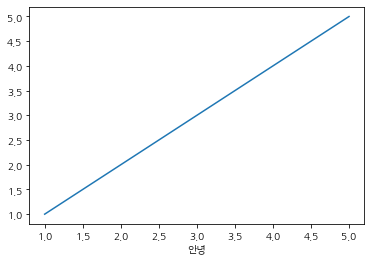

In [3]:
# # 테스트
# import matplotlib.pyplot as plt
# plt.plot([1,2,3,4,5], [1,2,3,4,5])
# plt.xlabel("안녕")

#### 모델 학습

In [5]:
# 학습 전 현재 경로 확인

In [33]:
cd /home/jngmk/Downloads/datasets/yolov5

/home/jngmk/Downloads/datasets/yolov5


In [30]:
os.getcwd()

'/home/jngmk/Downloads/datasets/yolov5'

In [6]:
# yolov5 전이학습
!python train.py --img 224 --batch 20 --epochs 20 --data data/data.yaml --device cuda:0 --cfg ./models/yolov5s.yaml --weights yolov5s.pt --name yolov5s_results_ver

wandb: Currently logged in as: hyeeein. Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=./models/yolov5s.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=20, imgsz=224, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=cuda:0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results_ver, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
remote: Enumerating objects: 1033, done.
remote: Counting objects: 100% (468/468), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 1033 (delta 431), reused 441 (delta 419), pack-reused 565
Receiving objects: 100% (1033/1033), 247.76 KiB | 8.26 MiB/s, done.
Resolving de

In [ ]:
# AttributeError: 'NoneType' object has no attribute 'python_exit_status'
# 속성 이름이 잘못됐거나 없는 속성을 가져오려고 하면 오류가 발생
# 즉, '검색 되어지는 앖이 하나도 없을 때' 발생하는 에러

#### 모델 테스트

In [7]:
os.getcwd()

'/home/jngmk/Downloads/datasets/yolov5'

In [8]:
cd '/home/jngmk/Downloads/datasets/yolov5'

/home/jngmk/Downloads/datasets/yolov5


In [39]:
test_img_path = [os.path.join(test_images_dir, i) for i in test_images]

# for test_img in test_img_path:
#     !python detect.py --weights runs/train/yolov5_results_ver3/weights/best.pt --img 224 --conf 0.5 --source "{test_img}"

!python detect.py --weights runs/train/yolov5s_results_ver3/weights/best.pt --img 224 --conf 0.5 --source "{test_img_path[15]}"

detect: weights=['runs/train/yolov5s_results_ver3/weights/best.pt'], source=/home/jngmk/Downloads/datasets/yolov5/dataset/images/test/V006_79_0_00_04_03_13_0_c25_20201030_0133_S01_1.jpg, data=data/coco128.yaml, imgsz=[224, 224], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-170-gbff6e51 torch 1.11.0 CUDA:0 (NVIDIA GeForce GTX 1070 Ti, 8116MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /home/jngmk/Downloads/datasets/yolov5/dataset/images/test/V006_79_0_00_04_03_13_0_c25_20201030_0133_S01_1.jpg: 128x224 1 정상, Done. (0.009s)
Speed: 0.3ms pre-process, 8.7ms inference, 0.9ms NMS per image at shape (1, 3, 224, 224)
Results saved to

---

#### 모델 학습 (2)

- 에포크, 배치 사이즈 조정

In [23]:
cd /home/jngmk/Downloads/datasets/yolo5/

[Errno 2] No such file or directory: '/home/jngmk/Downloads/datasets/yolo5/'
/home/jngmk/Downloads/datasets/yolov5


In [24]:
os.getcwd()

'/home/jngmk/Downloads/datasets/yolov5'

In [25]:
!python train.py --img 224 --batch 32 --epochs 30 --data data/data.yaml --device cuda:0 --cfg ./models/yolov5s.yaml --weights yolov5s.pt --name yolov5s_results_ver4

wandb: Currently logged in as: hyeeein. Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=./models/yolov5s.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=30, batch_size=32, imgsz=224, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=cuda:0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results_ver4, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 7 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.1-170-gbff6e51 torch 1.11.0 CUDA:0 (NVIDIA GeForce GTX 1070 Ti, 8116MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, war

#### 모델 테스트 (2)

In [32]:
test_img_path = [os.path.join(test_images_dir, i) for i in test_images]

!python detect.py --weights runs/train/yolov5s_results_ver4/weights/best.pt --img 224 --conf 0.5 --source '{test_img_path[53]}'

detect: weights=['runs/train/yolov5s_results_ver4/weights/best.pt'], source=/home/jngmk/Downloads/datasets/yolov5/dataset/images/test/V006_79_0_00_04_03_12_0_b10_20201021_0043_S01_1.jpg, data=data/coco128.yaml, imgsz=[224, 224], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-170-gbff6e51 torch 1.11.0 CUDA:0 (NVIDIA GeForce GTX 1070 Ti, 8116MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /home/jngmk/Downloads/datasets/yolov5/dataset/images/test/V006_79_0_00_04_03_12_0_b10_20201021_0043_S01_1.jpg: 128x224 1 정상, Done. (0.009s)
Speed: 0.2ms pre-process, 9.0ms inference, 0.9ms NMS per image at shape (1, 3, 224, 224)
Results saved to

---

#### 모델 학습 (3)

- 에포크, 배치 사이즈 조정

In [33]:
cd /home/jngmk/Downloads/datasets/yolo5/

[Errno 2] No such file or directory: '/home/jngmk/Downloads/datasets/yolo5/'
/home/jngmk/Downloads/datasets/yolov5


In [34]:
os.getcwd()

'/home/jngmk/Downloads/datasets/yolov5'

In [35]:
!python train.py --img 224 --batch 64 --epochs 50 --data data/data.yaml --device cuda:0 --cfg ./models/yolov5s.yaml --weights yolov5s.pt --name yolov5s_results_ver5

wandb: Currently logged in as: hyeeein. Use `wandb login --relogin` to force relogin
train: weights=yolov5s.pt, cfg=./models/yolov5s.yaml, data=data/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=64, imgsz=224, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=cuda:0, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5s_results_ver5, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 7 commits. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.1-170-gbff6e51 torch 1.11.0 CUDA:0 (NVIDIA GeForce GTX 1070 Ti, 8116MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, war

#### 모델 테스트 (3)

In [42]:
test_img_path = [os.path.join(test_images_dir, i) for i in test_images]

!python detect.py --weights runs/train/yolov5s_results_ver5/weights/best.pt --img 224 --conf 0.5 --source '{test_img_path[19]}'

detect: weights=['runs/train/yolov5s_results_ver5/weights/best.pt'], source=/home/jngmk/Downloads/datasets/yolov5/dataset/images/test/V006_79_0_00_06_03_13_0_b02_20201117_0014_S01_1.jpg, data=data/coco128.yaml, imgsz=[224, 224], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-170-gbff6e51 torch 1.11.0 CUDA:0 (NVIDIA GeForce GTX 1070 Ti, 8116MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
image 1/1 /home/jngmk/Downloads/datasets/yolov5/dataset/images/test/V006_79_0_00_06_03_13_0_b02_20201117_0014_S01_1.jpg: 128x224 2 정상s, Done. (0.009s)
Speed: 0.2ms pre-process, 8.8ms inference, 0.9ms NMS per image at shape (1, 3, 224, 224)
Results saved t

---

#### 참고 사이트

1. 파이썬 이미지 확장자 맞추기

https://gongdolhouse.tistory.com/entry/Python3-%ED%8C%8C%EC%9D%BC-%ED%99%95%EC%9E%A5%EC%9E%90%EB%AA%85-%EC%9D%BC%EA%B4%84-%EB%B3%80%EA%B2%BD%EB%B3%80%EA%B2%BD-%EC%BD%94%EB%93%9C


2. 숨김파일 제외

https://joyae.github.io/2020-03-15-how-to-get-file-list-on-certain-directory/


3. 파일 복사 (copyfile)

https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=dlaehd_king&logNo=10067290010

https://blog.naver.com/PostView.naver?blogId=hankrah&logNo=222409731893&categoryNo=64&parentCategoryNo=0&viewDate=&currentPage=1&postListTopCurrentPage=1&from=postView

4. Yolov5 json to txt 라벨링 파일 변환

https://haobin-tan.netlify.app/ai/computer-vision/object-detection/coco-json-to-yolo-txt/


5. Yolov5 모델

https://bigdata-analyst.tistory.com/195

https://lynnshin.tistory.com/47

https://settembre.tistory.com/459


6. Yolov5 모델 실행 중 AttributeError 에러 발생

https://lovelydiary.tistory.com/16